# Teste de viabilidade

Este notebook testa a viabilidade dos algoritmos do módulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.

## Carregamento e organização dos dados importados do Diorisis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas, sent_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

Neste teste, usaremos como corpus os textos de historiografia e prosa filosófica (diálogos e tratados) de autores do período clássico:

- Historiografia:
    - Heródoto
    - Xenofonte:
        - Ciropédia
        - Anábase
        - Helênica
    - Tucídides
- Prosa filosófica:
    - Platão
    - Xenofonte:
        - Agesilau
        - Hierão
        - Simpósio
        - Apologia
        - Memorabilia

In [7]:
DATA = "data.csv"
SENTS = "sents.csv"
REAPROVEITAR = True
TOKENS = False
if (DATA not in os.listdir() or SENTS not in os.listdir()) or not REAPROVEITAR:
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
        "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
    ]

    corpus = carrega_textos(autores=['Herodotus', 
                                     'Thucydides', 
                                     'Plato', 
                                     'Xenophon (0032)', # Exclui Xenofonte de Éfeso 
                                     ],
                            diorisis_path=DIORISIS_PATH,
                            ignore=ignorados,
                            verbose=False)
    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)
        
else:
    print('Carregando dataframe previamente salvo')
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(TOKENS)

Criando DF para: Herodotus (0016) - Histories (001).json
Criando DF para: Thucydides (0003) - History (001).json
Criando DF para: Plato (0059) - Cleitophon (029).json
Criando DF para: Plato (0059) - Menexenus (028).json
Criando DF para: Plato (0059) - Symposium (011).json
Criando DF para: Plato (0059) - Hipparchus (015).json
Criando DF para: Plato (0059) - Lovers (016).json
Criando DF para: Plato (0059) - Minos (033).json
Criando DF para: Plato (0059) - Phaedrus (012).json
Criando DF para: Plato (0059) - Epinomis (035).json
Criando DF para: Plato (0059) - Apology (002).json
Criando DF para: Plato (0059) - Protagoras (022).json
Criando DF para: Plato (0059) - Timaeus (031).json
Criando DF para: Plato (0059) - Hippias Minor (026).json
Criando DF para: Plato (0059) - Sophist (007).json
Criando DF para: Plato (0059) - Gorgias (023).json
Criando DF para: Plato (0059) - Laches (019).json
Criando DF para: Plato (0059) - Critias (032).json
Criando DF para: Plato (0059) - Euthyphro (001).json
C

**Formato do DF**: ainda não decidi se seria mais eficiente utilizar um data frame organizado por token ou por sentenças. A implementação de ambos é muito semelhante e pode ser vista em `../src/lexicogenero/ferramentas/diorisis_parser.py`

In [8]:
df_tokens

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories
...,...,...,...,...,...,...,...,...,...,...
63970,3804,7.8.24.1,πρὸς,πρός,preposition,indeclform (prep),14,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63971,3804,7.8.24.1,Τισσαφέρνην,Τισσαφέρνης,proper,masc acc sg;masc acc sg (attic epic ionic),15,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63972,3804,7.8.24.1,καὶ,καί,conjunction,indeclform (conj),16,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis
63973,3804,7.8.24.1,Φαρνάβαζον,Φαρνάβαζος,proper,masc acc sg,17,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis


In [19]:
df_sents

,sent_id,location,forms,lemmata,file,author,text,lst_lemmata,genero
0,1,1.t.1,"Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ,...",Ἡρόδοτος Ἁλικαρνησσεύς ἱστορία ἀπόδεξις ὅδε ὡς...,Herodotus (0016) - Histories (001).json,Herodotus,Histories,"[Ἡρόδοτος, Ἁλικαρνησσεύς, ἱστορία, ἀπόδεξις, ὅ...",hist
1,2,1.1.1,Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασ...,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,Herodotus (0016) - Histories (001).json,Herodotus,Histories,"[Πέρσευς, μέν, νῦν, ὁ, λόγιος, Φοῖνιξ, αἴτιος,...",hist
2,3,1.1.2,τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσση...,οὗτος γάρ ἀπό ὁ Ἐρυθραί καλέω θάλασσα ἀφικνέομ...,Herodotus (0016) - Histories (001).json,Herodotus,Histories,"[οὗτος, γάρ, ἀπό, ὁ, Ἐρυθραί, καλέω, θάλασσα, ...",hist
3,4,1.1.7,τὸ δὲ Ἄργος τοῦτον τὸν χρόνον προεῖχε ἅπασι τῶ...,ὁ δέ Ἄργος οὗτος ὁ χρόνος προέχω ἅπας ὁ ἐν ὁ ν...,Herodotus (0016) - Histories (001).json,Herodotus,Histories,"[ὁ, δέ, Ἄργος, οὗτος, ὁ, χρόνος, προέχω, ἅπας,...",hist
4,5,1.1.9,ἀπικομένους δὲ τούς Φοίνικας ἐς δὴ τὸ Ἄργος το...,ἀφικνέομαι δέ ὁ Φοῖνιξ εἰς δή ὁ Ἄργος οὗτος δι...,Herodotus (0016) - Histories (001).json,Herodotus,Histories,"[ἀφικνέομαι, δέ, ὁ, Φοῖνιξ, εἰς, δή, ὁ, Ἄργος,...",hist
...,...,...,...,...,...,...,...,...,...
3799,3800,7.8.23.1,ἔπειτα πάλιν ἀφικνοῦνται εἰς Πέργαμον .,ἔπειτα πάλιν ἀφικνέομαι εἰς Πέργαμον,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,"[ἔπειτα, πάλιν, ἀφικνέομαι, εἰς, Πέργαμον]",hist
3800,3801,7.8.23.2,ἐνταῦθα τὸν θεὸν ἠσπάσατο Ξενοφῶν ·,ἐνταῦθα ὁ θεός ἀσπάζομαι Ξενοφῶν,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,"[ἐνταῦθα, ὁ, θεός, ἀσπάζομαι, Ξενοφῶν]",hist
3801,3802,7.8.23.3,συνέπραττον γὰρ καὶ οἱ Λάκωνες καὶ οἱ λοχαγοὶ ...,συμπράσσω γάρ καί ὁ Λάκων καί ὁ λοχαγός καί ὁ ...,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,"[συμπράσσω, γάρ, καί, ὁ, Λάκων, καί, ὁ, λοχαγό...",hist
3802,3803,7.8.23.5,ὥστε ἱκανὸν εἶναι καὶ ἄλλον ἤδη εὖ ποιεῖν .,ὥστε ἱκανός εἰμί καί ἄλλος ἤδη εὖ ποιέω,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,"[ὥστε, ἱκανός, εἰμί, καί, ἄλλος, ἤδη, εὖ, ποιέω]",hist


## Anotando Gênero

In [12]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [15]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df_tokens['genero'] = np.nan
df_tokens.loc[df_tokens.file.isin(hist), 'genero'] = "hist"
df_tokens.genero.fillna("filo", inplace=True)
df_sents['genero'] = np.nan
df_sents.loc[df_sents.file.isin(hist), 'genero'] = "hist"
df_sents.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, será necessário ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiográfica e prosa filosófica, a seleção parece razoável.
Qualquer tentativa de aumentar os dados de historiografia forçaria aumentar o escopo temporal (o próximo autor seria Políbio, já do período helenístico).
Nota-se que a diferença aumenta quando tratamos de sentenças e não de tokens, indicando que as sentenças em textos historiográficos devem ser um pouco mais longas na média.

<AxesSubplot:>

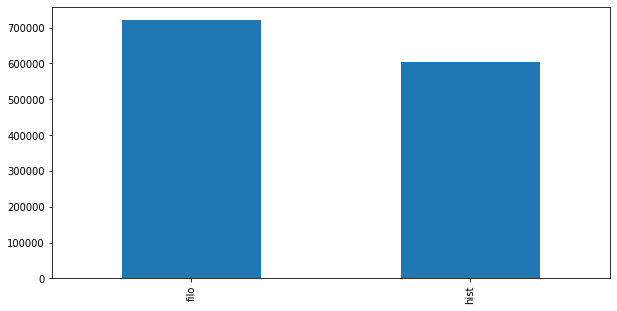

In [21]:
df_tokens.genero.value_counts().plot(kind='bar')

<AxesSubplot:>

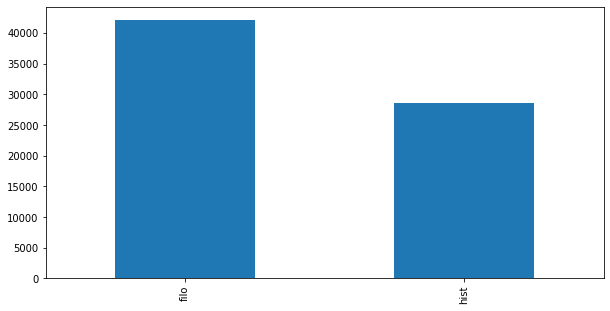

In [20]:
df_sents.genero.value_counts().plot(kind='bar')

## Verbos por gênero (dataframe de tokens)

In [24]:
df_verbos = df_tokens.loc[(df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST))]
df_verbos

,sent_id,location,form,lemma,POS,analyses,id,file,author,text,genero
30,1,1.t.1,ἀποδεχθέντα,ἀποδέχομαι,verb,aor part pass neut nom/voc/acc pl;aor part pas...,28,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
42,1,1.t.1,ἐπολέμησαν,πολεμέω,verb,aor ind act 3rd pl,38,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
62,3,1.1.2,καλεομένης,καλέω,verb,fut part mid fem gen sg (attic epic ionic);pre...,6,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
64,3,1.1.2,ἀπικομένους,ἀφικνέομαι,verb,aor part mid masc acc pl (ionic),8,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
71,3,1.1.2,οἰκήσαντας,οἰκέω,verb,aor part act masc acc pl,14,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
...,...,...,...,...,...,...,...,...,...,...,...
63940,3802,7.8.23.3,λαβεῖν,λαμβάνω,verb,aor inf act (attic epic doric),18,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,hist
63960,3804,7.8.24.1,παραγενόμενος,παραγίγνομαι,verb,aor part mid masc nom sg,4,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,hist
63961,3804,7.8.24.1,παρέλαβε,παραλαμβάνω,verb,aor ind act 3rd sg,5,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,hist
63965,3804,7.8.24.1,συμμείξας,συμμίγνυμι,verb,aor part act masc nom/voc sg (attic epic ionic),9,Xenophon (0032) - Anabasis (006).json,Xenophon,Anabasis,hist


A filtragem não causa mudança na proporção entre documentos de historiografia e filosofia.

<AxesSubplot:>

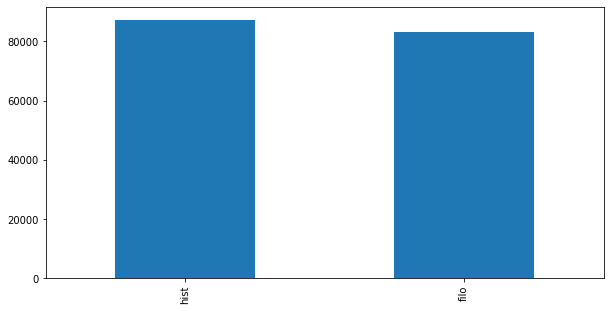

In [25]:
df_verbos.genero.value_counts().plot(kind='bar')

In [26]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

οἴομαι           1767
οἶδα             1482
φαίνω            1204
βούλομαι         1177
δεῖ              1026
                 ... 
προπαιδεύω          1
μολύνω              1
διαίνω              1
ὑπεραγανακτέω       1
ἐφέζομαι            1
Name: lemma, Length: 3663, dtype: int64

<AxesSubplot:ylabel='Density'>

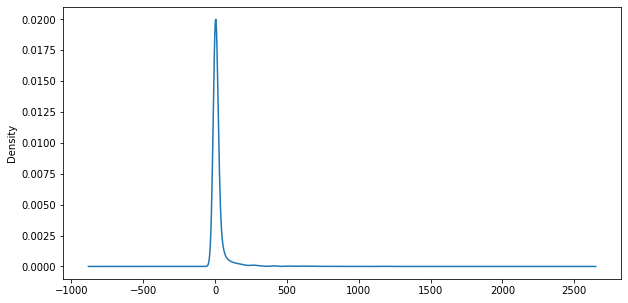

In [27]:
filo_verbos.value_counts().plot(kind='density')

In [28]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

βούλομαι        1177
λαμβάνω          994
ἀφικνέομαι       915
ἔρχομαι          872
πάρειμι          822
                ... 
ἐπεικάζω           1
ἀποκηδεύω          1
πυκνόω             1
καθιππάζομαι       1
ἐξαυλίζομαι        1
Name: lemma, Length: 4331, dtype: int64

<AxesSubplot:ylabel='Density'>

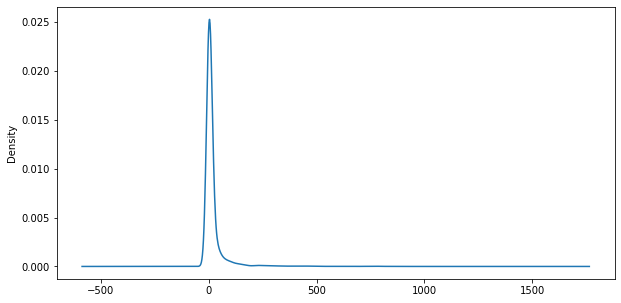

In [29]:
hist_verbos.value_counts().plot(kind='density')

Reorganizando como lista de duplas:

In [30]:
hist_verbos = {p: n for n, p in hist_verbos.items()}
filo_verbos = {p: n for n, p in filo_verbos.items()}

In [31]:
C_hist_verbos = len(hist_verbos)
C_filo_verbos = len(filo_verbos)

In [32]:
p_hist_verbos = {p: np.log(n/C_hist_verbos) for p, n in hist_verbos.items()}
p_filo_verbos = {p: np.log(n/C_filo_verbos) for p, n in filo_verbos.items()}

In [33]:
p_filo_verbos

{'διηγέομαι': -4.947941224757332,
 'διαλέγω': 1.0699030662813171,
 'ψέγω': 0.739164501180482,
 'ὑπερεπαινέω': -0.6569550519665285,
 'ἀπομνημονεύω': -4.111693200556713,
 'ἐπαινέω': 0.8032874099561597,
 'μέμφομαι': 0.9213556883764422,
 'προσποιέω': -0.42740761545300476,
 'φροντίζω': 0.24693685631077192,
 'διεξέρχομαι': 2.360266620509425,
 'τυγχάνω': 1.1093830856478757,
 'ἡγέομαι': 1.0525211814678428,
 'ἀκούω': 1.101701515184501,
 'φαίνω': 1.0885518416422684,
 'δέω': 0.6879466761609798,
 'δίδωμι': 0.9339874352823427,
 'δέχομαι': 0.09150576657746914,
 'ἐθέλω': 1.0200775283127306,
 'ὠφελέω': 0.789623136295288,
 'προθυμέομαι': -0.4679854650894983,
 'ὑπομένω': 1.11010302808358,
 'γιγνώσκω': 1.0909389158569152,
 'ἀσκέω': 1.0585066632108804,
 'διώκω': -0.44174175632829615,
 'φεύγω': 0.5293266383250749,
 'συγγίγνομαι': 1.0022004011054981,
 'ἐκπλήσσω': 0.21794304691524427,
 'ἐπιτιμάω': 1.9229505606452015,
 'ὑμνέω': 1.0164287889952088,
 'φέρω': 0.9879699545764707,
 'ἀγνοέω': -0.618727256756199,
 '

## Naive Bayes


### Apenas de tokens

O resultado é terrível, provavelmente porque a implementação do modelo não é a melhor, afinal o `DOCUMENTO` e suas componentes são a mesma entidade.

In [34]:
x, y = df_verbos.lemma, df_verbos.genero

In [35]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

In [36]:
vocab_filo = Counter(filo)
vocab_hist = Counter(hist)

In [37]:
n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

In [38]:
n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [39]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [40]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

In [41]:
teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")
        
perf_counter = Counter(performance_labels)

In [42]:
perf_counter

Counter({'VN': 17407, 'FP': 16718})

### Com sentenças

In [43]:
# TODO: Implementar